
All imports successful!
TensorFlow Version: 2.20.0

SECTION 1: DATA LOADING AND PREPROCESSING

Loading dataset...
Dataset Shape: (1048575, 15)
Columns: ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   marketplace        1048575 non-null  object
 1   customer_id        1048575 non-null  int64 
 2   review_id          1048575 non-null  object
 3   product_id         1048575 non-null  object
 4   product_parent     1048575 non-null  int64 
 5   product_title      1048575 non-null  object
 6   product_category   1048575 non-null  object
 7   star_rating        1048575 n

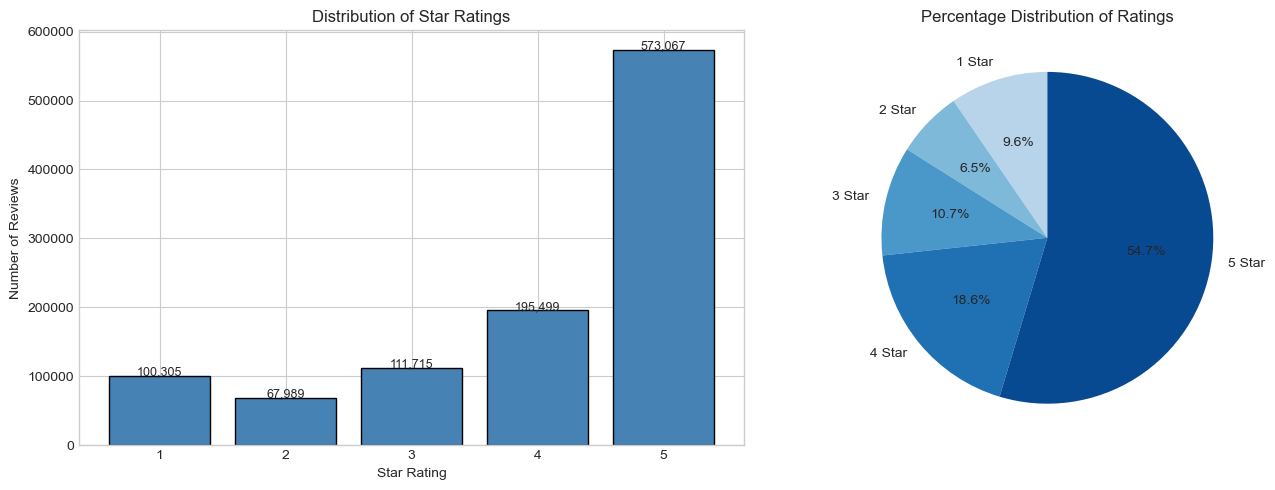

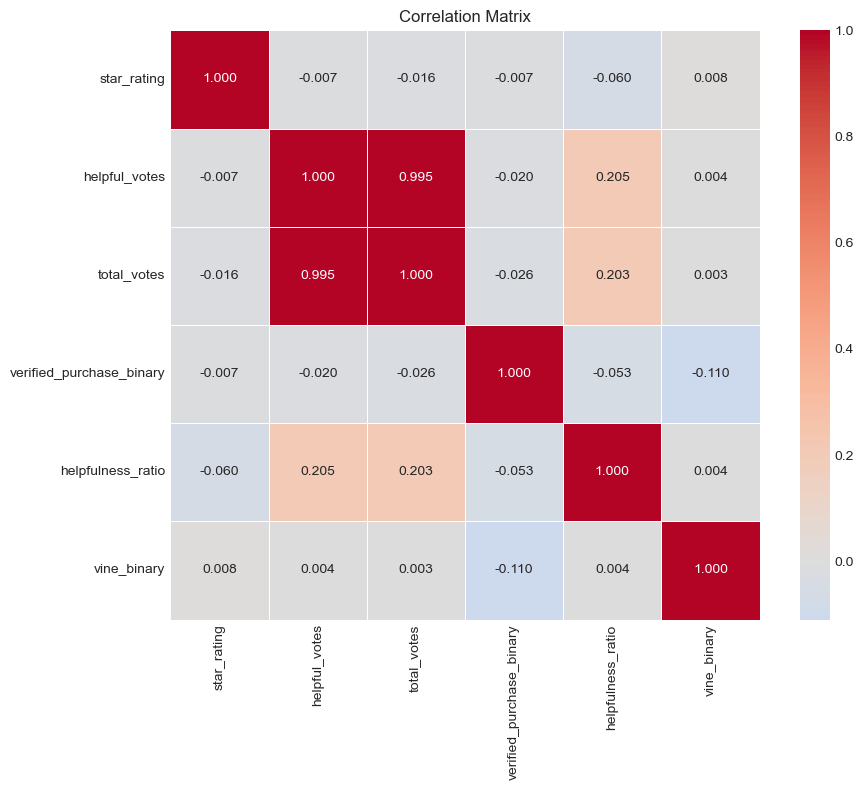

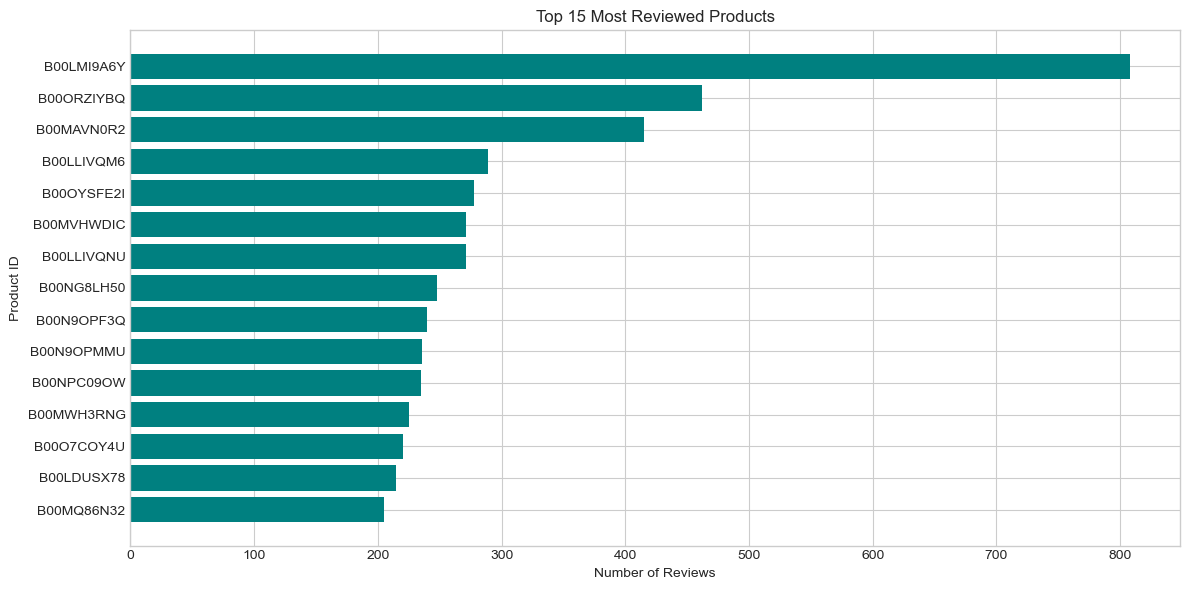

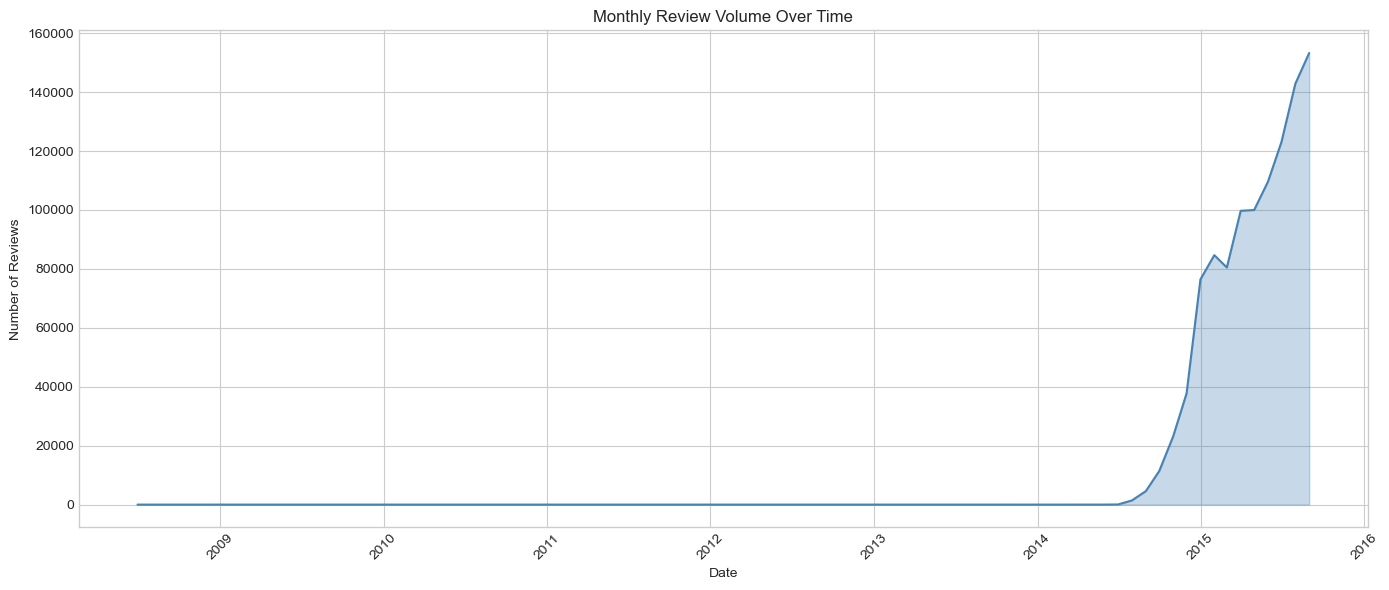

<Figure size 1000x600 with 0 Axes>

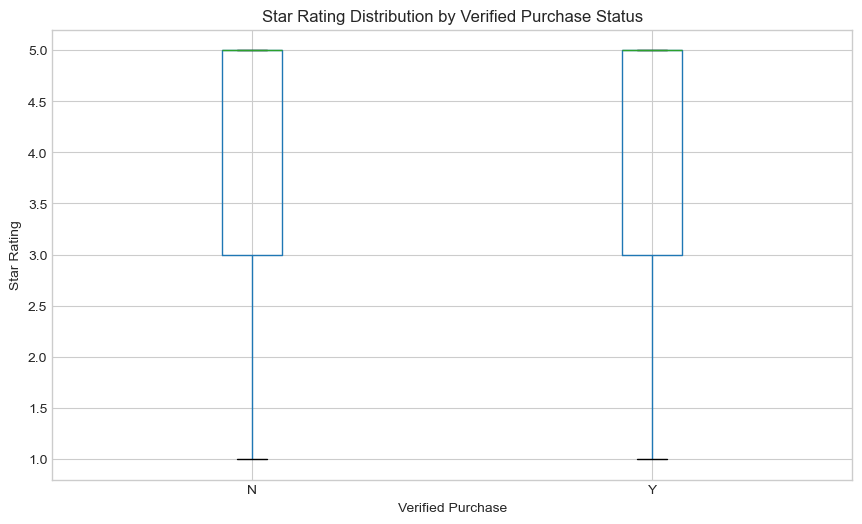


--- Statistical Analysis ---

Hypothesis Test: Verified vs Non-Verified Purchases
Verified Mean: 4.0207, Count: 969,915
Non-Verified Mean: 4.0551, Count: 78,660
Mann-Whitney U Test: U-statistic=36,856,749,574, P-value=1.00e+00
Conclusion: No significant difference

Bayesian Analysis - P(Helpful): 0.9223
P(Helpful | Star Rating):
  Rating 1: 0.8009
  Rating 2: 0.8766
  Rating 3: 0.9057
  Rating 4: 0.9570
  Rating 5: 0.9598

--- Feature Engineering ---
Review Length - Mean: 136.77, Max: 15649


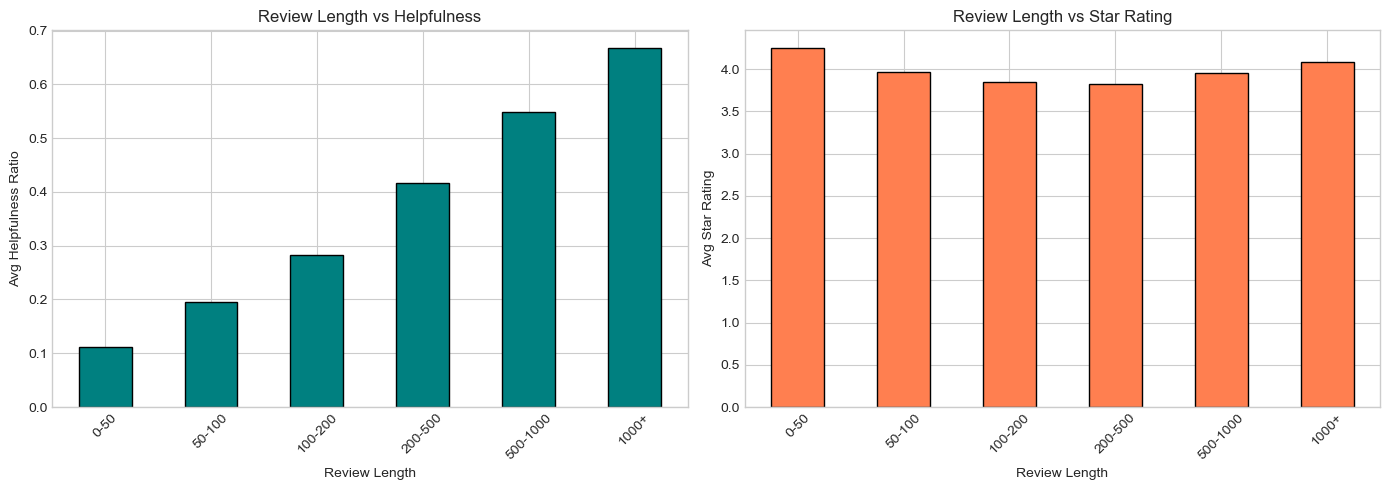


Section 1 Complete!

SECTION 2: MACHINE LEARNING MODELS

Working with 100,000 reviews
Preprocessing text...
Creating TF-IDF features...
TF-IDF Matrix Shape: (100000, 5000)
Extracting sentiment features...


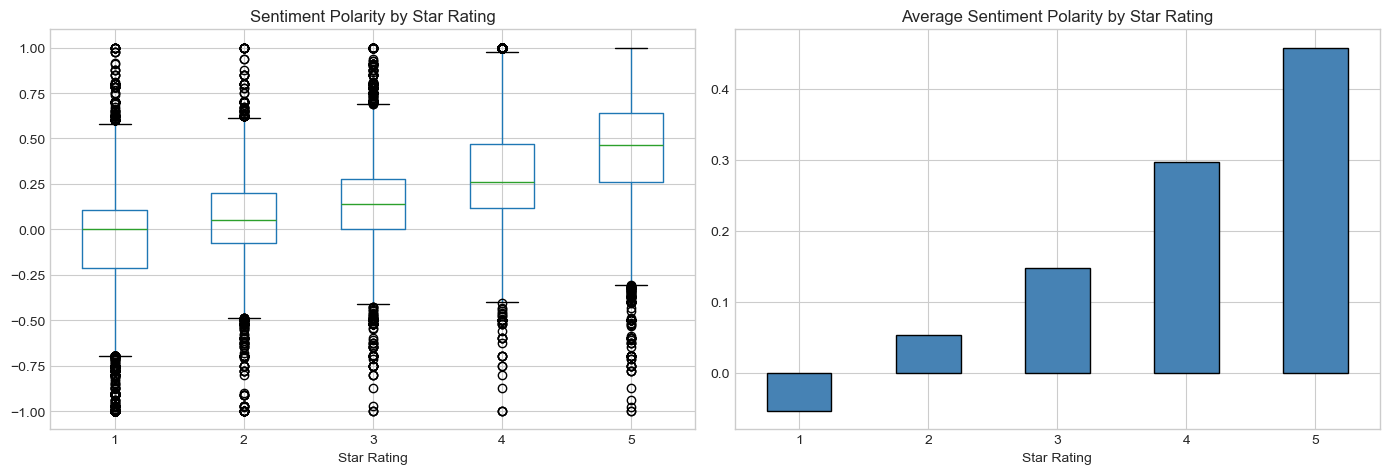

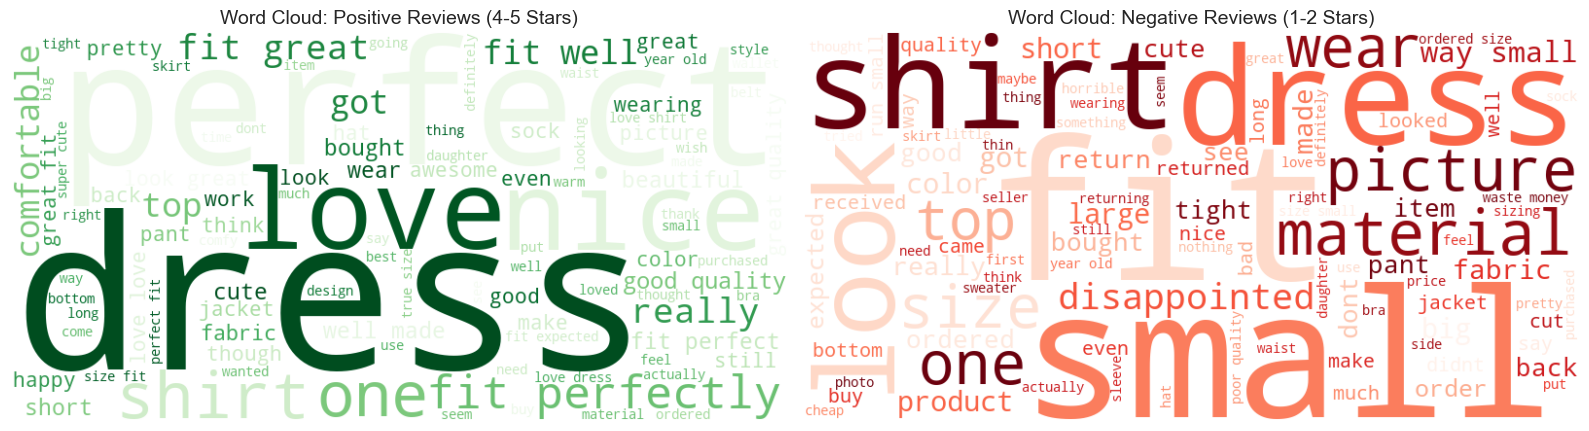


--- Preparing Features ---
Combined Feature Matrix Shape: (100000, 5007)
Classification Target Distribution:
positive    73142
negative    16136
neutral     10722
Name: count, dtype: int64
Training set: 80,000, Test set: 20,000

--- Regression Models ---
Linear Regression - R2: 0.6067, RMSE: 0.8390
Ridge Regression - R2: 0.6129, RMSE: 0.8325
Lasso Regression - R2: 0.3259, RMSE: 1.0985

Regression Models Comparison:
            Model  Train R2  Test R2  Test RMSE  Test MAE
Linear Regression  0.649356 0.606748   0.839032  0.621454
 Ridge Regression  0.645281 0.612893   0.832452  0.618409
 Lasso Regression  0.321057 0.325910   1.098506  0.856714


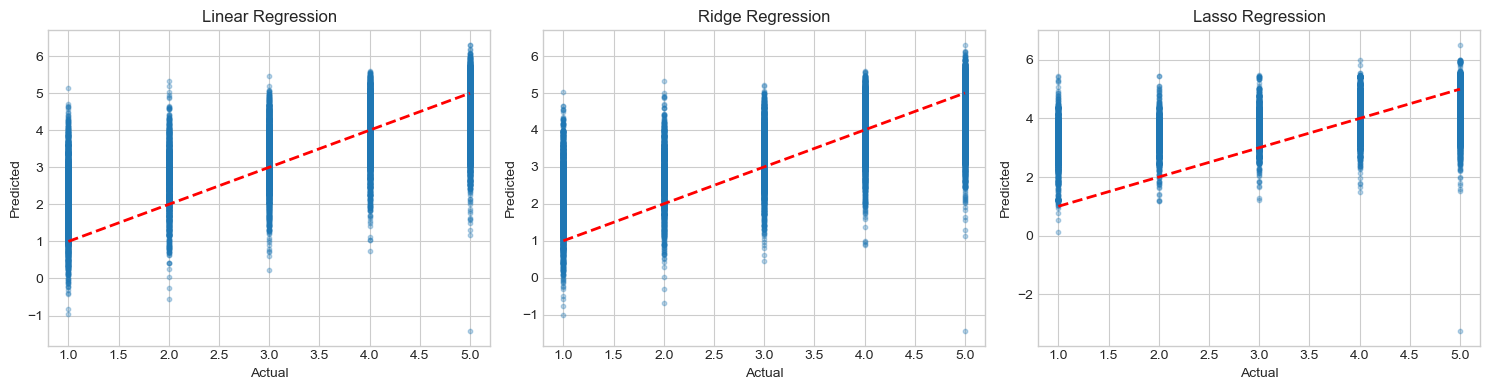


--- Classification Models ---
Logistic Regression - Accuracy: 0.8161, F1: 0.7720
Decision Tree - Accuracy: 0.7883, F1: 0.7451
Random Forest - Accuracy: 0.7441, F1: 0.6475
Naive Bayes - Accuracy: 0.8194, F1: 0.7793

Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.09      0.16      3236
     neutral       0.00      0.00      0.00      2163
    positive       0.74      1.00      0.85     14601

    accuracy                           0.74     20000
   macro avg       0.56      0.36      0.34     20000
weighted avg       0.69      0.74      0.65     20000



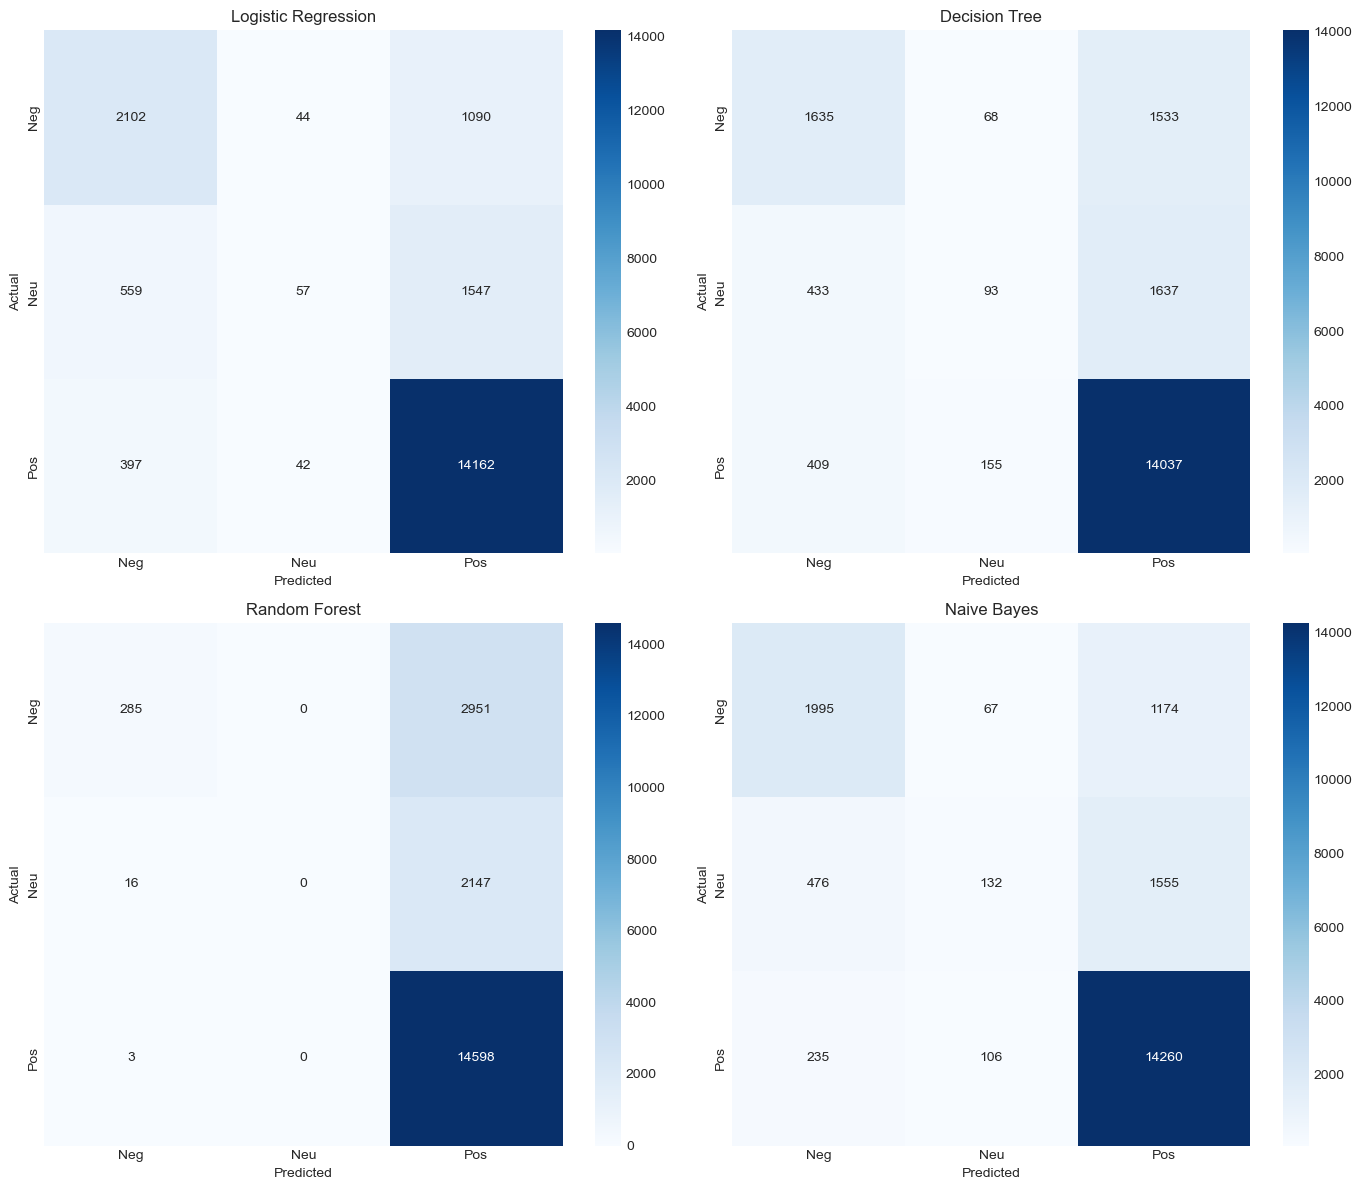


--- Handling Imbalanced Data ---
RF with Class Weighting - Accuracy: 0.7441, F1: 0.7628

--- Ensemble Learning ---
AdaBoost - Accuracy: 0.7957, F1: 0.7443
Gradient Boosting - Accuracy: 0.8189, F1: 0.7805
Voting Classifier - Accuracy: 0.8030, F1: 0.7479

CLASSIFICATION MODELS COMPARISON
              Model  Accuracy  Precision  Recall  F1-Score
  Gradient Boosting   0.81890   0.778168 0.81890  0.780500
        Naive Bayes   0.81935   0.778873 0.81935  0.779318
Logistic Regression   0.81605   0.769778 0.81605  0.771952
  Voting Classifier   0.80295   0.748715 0.80295  0.747907
      Decision Tree   0.78825   0.734184 0.78825  0.745073
           AdaBoost   0.79575   0.730250 0.79575  0.744308
      Random Forest   0.74415   0.692776 0.74415  0.647522

Section 2 Complete!

SECTION 3: DEEP LEARNING MODELS
Vocabulary Size: 35650
Padded Sequences Shape: (100000, 200)
Classes: ['negative' 'neutral' 'positive']
DL Training set: (80000, 200), Test set: (20000, 200)

--- Training DNN Model ---


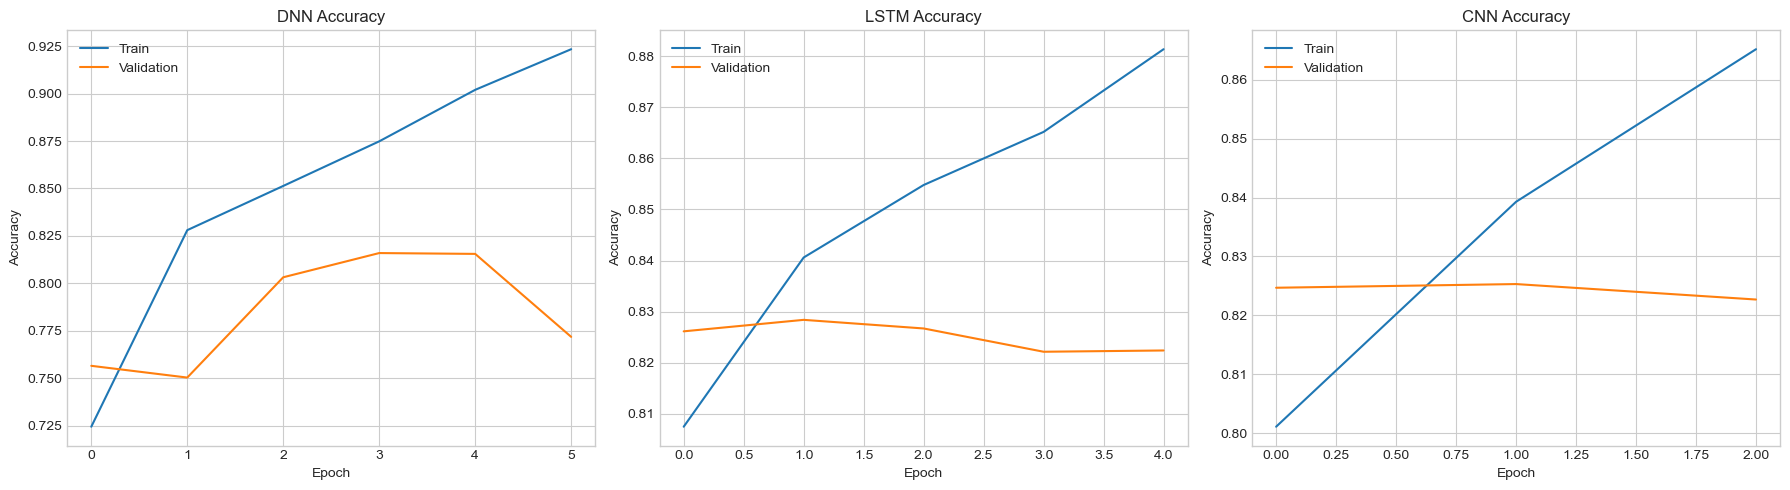

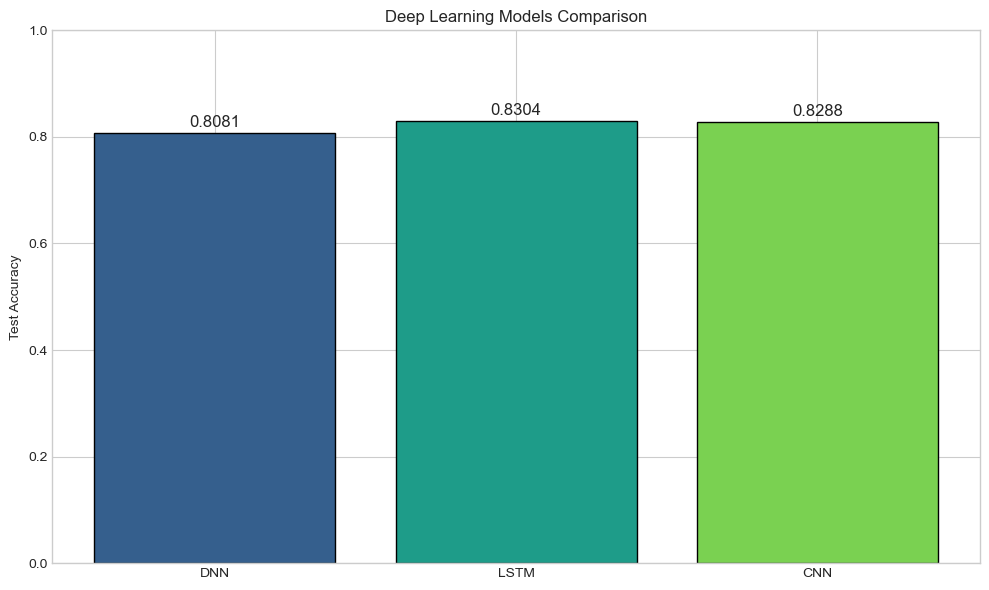


Section 3 Complete!

SECTION 4: LLMs AND RETRIEVAL-BASED AI
Products for LLM analysis: 1000

--- Transformer Sentiment Analysis ---


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Sample Transformer Results:
  Review: This is actually a Christmas gift for my daughter in NY. I figure she will love ...
  Sentiment: {'label': 'POSITIVE', 'score': 0.9998493194580078}

  Review: fabric is great fits really well...
  Sentiment: {'label': 'POSITIVE', 'score': 0.9998500347137451}

  Review: Don't even know you have one on but have all of the support you need per what my...
  Sentiment: {'label': 'POSITIVE', 'score': 0.9981777667999268}


--- Text Summarization ---


config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Original (truncated): This shirt is for really really really skinny 34girls34. I say girls because the shirt I received was way tooooo small for me to get into. The shirt is meant to show your belly button so if you purchase it be warned it may be too small in size around breast area and waist, be ready to show your stom...
Summary: The shirt is meant to show your belly button so if you purchase it be warned it may be too small in size around breast area and waist. The quality of the shirt is very cheap. I am not a satisfied customer at all.

--- Vector Embeddings & Semantic Search ---


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Embeddings shape: (1000, 384)
FAISS index created with 1000 vectors

Search Query: 'comfortable and fits well'
Top Results:
  Rank 1: Product B00L5YLHUW, Rating: 5.00
  Rank 2: Product B00L4WIKXW, Rating: 5.00
  Rank 3: Product B00L5MQ6ZA, Rating: 4.00

--- RAG Implementation ---
Generated RAG Prompt:
Based on the following customer reviews, answer the question.

Context:
Product 1 (Rating: 5.0):
Quality good

Product 2 (Rating: 5.0):
good quality as expected. arrived on date promised.

Product 3 (Rating: 5.0):
Very satisfied with my purchase.

Question: What do customers say about product quality?

Answer:...

--- Fake Review Detection ---
Potential spam reviews detected: 4,993
Percentage: 4.99%

Spam vs Legitimate Comparison:
                   Legitimate  Potential Spam
review_length      114.167230      545.055077
word_count          22.067427      104.106749
avg_word_length      4.675864        4.841330
uppercase_ratio      0.040611        0.126386
exclamation_count    0.423495   

: 

In [ ]:
# =============================================================================
# E-COMMERCE PRODUCT REVIEWS ANALYSIS - COMPLETE CAPSTONE ONE PROJECT
# =============================================================================

# =============================================================================
# IMPORTS AND SETUP
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import zipfile
import io
from datetime import datetime
from scipy import stats

# Sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, IsolationForest
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix)
from scipy.sparse import hstack

# NLP imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Embedding, LSTM, GRU, Conv1D,
                                     MaxPooling1D, Flatten, GlobalMaxPooling1D,
                                     BatchNormalization, Bidirectional)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# LLM and Embeddings
from transformers import pipeline
from sentence_transformers import SentenceTransformer
import faiss

import joblib

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("All imports successful!")
print(f"TensorFlow Version: {tf.__version__}")

# =============================================================================
# SECTION 1: DATA LOADING AND PREPROCESSING
# =============================================================================
print("\n" + "="*70)
print("SECTION 1: DATA LOADING AND PREPROCESSING")
print("="*70)

# File paths
DATA_PATH = r"C:\Users\edwar\OneDrive\Documents\AI & Machine Learning Bootcamp\amazon_reviews_us_Apparel_v1_00.csv.zip"
IMAGES_PATH = r"C:\Users\edwar\OneDrive\Documents\AI & Machine Learning Bootcamp\Images Capstone.zip"

# Load dataset with correct method
print("\nLoading dataset...")
with zipfile.ZipFile(DATA_PATH, 'r') as z:
    file_name = z.namelist()[0]
    with z.open(file_name) as f:
        content = f.read().decode('utf-8')
        first_line = content.split('\n')[0]
        sep = '\t' if '\t' in first_line else ','
        df = pd.read_csv(io.StringIO(content), sep=sep, on_bad_lines='skip', low_memory=False)

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Display basic info
print("\n--- Dataset Info ---")
print(df.info())
print("\n--- Statistical Summary ---")
print(df.describe())

# Check missing values
print("\n--- Missing Values ---")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False))

# -----------------------------------------------------------------------------
# DATA CLEANING
# -----------------------------------------------------------------------------
print("\n--- Data Cleaning ---")
df_clean = df.copy()

# Handle missing values
print(f"Missing review_body before: {df_clean['review_body'].isnull().sum()}")
df_clean['review_body'] = df_clean['review_body'].fillna('')
df_clean['review_headline'] = df_clean['review_headline'].fillna('')
print(f"Missing review_body after: {df_clean['review_body'].isnull().sum()}")

# Handle star_rating
print(f"Missing star_rating before: {df_clean['star_rating'].isnull().sum()}")
df_clean = df_clean.dropna(subset=['star_rating'])
df_clean['star_rating'] = df_clean['star_rating'].astype(int)
print(f"Missing star_rating after: {df_clean['star_rating'].isnull().sum()}")

# Convert review_date to datetime
df_clean['review_date'] = pd.to_datetime(df_clean['review_date'], errors='coerce')
df_clean['review_year'] = df_clean['review_date'].dt.year
df_clean['review_month'] = df_clean['review_date'].dt.month
df_clean['review_day'] = df_clean['review_date'].dt.day
df_clean['review_dayofweek'] = df_clean['review_date'].dt.dayofweek
df_clean['review_quarter'] = df_clean['review_date'].dt.quarter
print(f"Date range: {df_clean['review_date'].min()} to {df_clean['review_date'].max()}")

# Text cleaning function
def clean_text(text):
    if pd.isna(text) or text == '':
        return ''
    text = str(text)
    text = re.sub(r'<[^>]+>', '', text)  
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  
    text = re.sub(r'[^\w\s.,!?\'\-]', '', text)  
    text = ' '.join(text.split())  
    return text.strip()

df_clean['review_body_clean'] = df_clean['review_body'].apply(clean_text)
df_clean['review_headline_clean'] = df_clean['review_headline'].apply(clean_text)

# Convert categorical to binary
df_clean['verified_purchase_binary'] = df_clean['verified_purchase'].map({'Y': 1, 'N': 0})
df_clean['vine_binary'] = df_clean['vine'].map({'Y': 1, 'N': 0})

# Handle votes
df_clean['helpful_votes'] = pd.to_numeric(df_clean['helpful_votes'], errors='coerce').fillna(0).astype(int)
df_clean['total_votes'] = pd.to_numeric(df_clean['total_votes'], errors='coerce').fillna(0).astype(int)
df_clean['helpfulness_ratio'] = np.where(df_clean['total_votes'] > 0,
                                          df_clean['helpful_votes'] / df_clean['total_votes'], 0)

print(f"\nCleaned dataset shape: {df_clean.shape}")

# -----------------------------------------------------------------------------
# EXPLORATORY DATA ANALYSIS
# -----------------------------------------------------------------------------
print("\n--- Exploratory Data Analysis ---")

# Summary statistics
print("\nStar Rating Statistics:")
print(f"Mean: {df_clean['star_rating'].mean():.4f}")
print(f"Median: {df_clean['star_rating'].median():.4f}")
print(f"Mode: {df_clean['star_rating'].mode()[0]}")
print(f"Std: {df_clean['star_rating'].std():.4f}")

# Rating distribution plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
rating_counts = df_clean['star_rating'].value_counts().sort_index()
axes[0].bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Star Rating')
axes[0].set_ylabel('Number of Reviews')
axes[0].set_title('Distribution of Star Ratings')
for i, v in enumerate(rating_counts.values):
    axes[0].text(rating_counts.index[i], v + 1000, f'{v:,}', ha='center', fontsize=9)

axes[1].pie(rating_counts.values, labels=[f'{i} Star' for i in rating_counts.index],
            autopct='%1.1f%%', startangle=90, colors=plt.cm.Blues(np.linspace(0.3, 0.9, 5)))
axes[1].set_title('Percentage Distribution of Ratings')
plt.tight_layout()
plt.show()

# Correlation matrix
numerical_cols = ['star_rating', 'helpful_votes', 'total_votes', 'verified_purchase_binary',
                  'helpfulness_ratio', 'vine_binary']
correlation_matrix = df_clean[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5, fmt='.3f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Top reviewed products
top_products = df_clean['product_id'].value_counts().head(15)
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_products)), top_products.values, color='teal')
plt.yticks(range(len(top_products)), top_products.index)
plt.xlabel('Number of Reviews')
plt.ylabel('Product ID')
plt.title('Top 15 Most Reviewed Products')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Time series plot
reviews_by_date = df_clean.groupby('review_date').size().reset_index(name='review_count')
reviews_by_date = reviews_by_date.set_index('review_date').resample('M').sum().reset_index()
plt.figure(figsize=(14, 6))
plt.plot(reviews_by_date['review_date'], reviews_by_date['review_count'], color='steelblue', linewidth=1.5)
plt.fill_between(reviews_by_date['review_date'], reviews_by_date['review_count'], alpha=0.3, color='steelblue')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.title('Monthly Review Volume Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Box plot by verified purchase
plt.figure(figsize=(10, 6))
df_clean.boxplot(column='star_rating', by='verified_purchase', figsize=(10, 6))
plt.title('Star Rating Distribution by Verified Purchase Status')
plt.suptitle('')
plt.xlabel('Verified Purchase')
plt.ylabel('Star Rating')
plt.show()

# -----------------------------------------------------------------------------
# STATISTICAL ANALYSIS
# -----------------------------------------------------------------------------
print("\n--- Statistical Analysis ---")

# Hypothesis Testing
verified_ratings = df_clean[df_clean['verified_purchase'] == 'Y']['star_rating']
non_verified_ratings = df_clean[df_clean['verified_purchase'] == 'N']['star_rating']

print("\nHypothesis Test: Verified vs Non-Verified Purchases")
print(f"Verified Mean: {verified_ratings.mean():.4f}, Count: {len(verified_ratings):,}")
print(f"Non-Verified Mean: {non_verified_ratings.mean():.4f}, Count: {len(non_verified_ratings):,}")

statistic, p_value = stats.mannwhitneyu(verified_ratings, non_verified_ratings, alternative='greater')
print(f"Mann-Whitney U Test: U-statistic={statistic:,.0f}, P-value={p_value:.2e}")
print(f"Conclusion: {'Verified purchases have significantly higher ratings' if p_value < 0.05 else 'No significant difference'}")

# Bayesian probability
df_voted = df_clean[df_clean['total_votes'] >= 5].copy()
df_voted['is_helpful'] = (df_voted['helpfulness_ratio'] > 0.5).astype(int)
print(f"\nBayesian Analysis - P(Helpful): {df_voted['is_helpful'].mean():.4f}")
print("P(Helpful | Star Rating):")
for rating in range(1, 6):
    subset = df_voted[df_voted['star_rating'] == rating]
    if len(subset) > 0:
        print(f"  Rating {rating}: {subset['is_helpful'].mean():.4f}")

# -----------------------------------------------------------------------------
# FEATURE ENGINEERING
# -----------------------------------------------------------------------------
print("\n--- Feature Engineering ---")

df_clean['review_length'] = df_clean['review_body_clean'].str.len()
df_clean['review_word_count'] = df_clean['review_body_clean'].str.split().str.len()
df_clean['headline_length'] = df_clean['review_headline_clean'].str.len()

print(f"Review Length - Mean: {df_clean['review_length'].mean():.2f}, Max: {df_clean['review_length'].max()}")

# Review length vs helpfulness
df_clean['length_bin'] = pd.cut(df_clean['review_length'],
                                 bins=[0, 50, 100, 200, 500, 1000, float('inf')],
                                 labels=['0-50', '50-100', '100-200', '200-500', '500-1000', '1000+'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
length_helpful = df_clean.groupby('length_bin')['helpfulness_ratio'].mean()
length_helpful.plot(kind='bar', color='teal', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Review Length')
axes[0].set_ylabel('Avg Helpfulness Ratio')
axes[0].set_title('Review Length vs Helpfulness')
axes[0].tick_params(axis='x', rotation=45)

length_rating = df_clean.groupby('length_bin')['star_rating'].mean()
length_rating.plot(kind='bar', color='coral', edgecolor='black', ax=axes[1])
axes[1].set_xlabel('Review Length')
axes[1].set_ylabel('Avg Star Rating')
axes[1].set_title('Review Length vs Star Rating')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Normalize numerical features
scaler = MinMaxScaler()
features_to_scale = ['total_votes', 'helpful_votes', 'review_length', 'review_word_count']
df_clean[[f'{f}_scaled' for f in features_to_scale]] = scaler.fit_transform(df_clean[features_to_scale].fillna(0))

print("\nSection 1 Complete!")

# =============================================================================
# SECTION 2: MACHINE LEARNING MODELS
# =============================================================================
print("\n" + "="*70)
print("SECTION 2: MACHINE LEARNING MODELS")
print("="*70)

# Sample data for faster processing
SAMPLE_SIZE = 100000
df_sample = df_clean.sample(n=min(SAMPLE_SIZE, len(df_clean)), random_state=RANDOM_STATE)
print(f"\nWorking with {len(df_sample):,} reviews")

# Advanced text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_for_ml(text):
    if pd.isna(text) or text == '':
        return ''
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

print("Preprocessing text...")
df_sample['review_processed'] = df_sample['review_body_clean'].apply(preprocess_text_for_ml)

# TF-IDF
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5, max_df=0.95)
tfidf_matrix = tfidf.fit_transform(df_sample['review_processed'].fillna(''))
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")

# Sentiment features
print("Extracting sentiment features...")
df_sample['sentiment_polarity'] = df_sample['review_body_clean'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity if x else 0)
df_sample['sentiment_subjectivity'] = df_sample['review_body_clean'].apply(
    lambda x: TextBlob(str(x)).sentiment.subjectivity if x else 0)

# Visualize sentiment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df_sample.boxplot(column='sentiment_polarity', by='star_rating', ax=axes[0])
axes[0].set_title('Sentiment Polarity by Star Rating')
axes[0].set_xlabel('Star Rating')
plt.suptitle('')

sentiment_by_rating = df_sample.groupby('star_rating')['sentiment_polarity'].mean()
sentiment_by_rating.plot(kind='bar', color='steelblue', edgecolor='black', ax=axes[1])
axes[1].set_title('Average Sentiment Polarity by Star Rating')
axes[1].set_xlabel('Star Rating')
axes[1].tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

# Word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
positive_text = ' '.join(df_sample[df_sample['star_rating'] >= 4]['review_processed'].dropna())
wordcloud_pos = WordCloud(width=800, height=400, background_color='white',
                          colormap='Greens', max_words=100).generate(positive_text if positive_text else 'empty')
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud: Positive Reviews (4-5 Stars)', fontsize=14)

negative_text = ' '.join(df_sample[df_sample['star_rating'] <= 2]['review_processed'].dropna())
wordcloud_neg = WordCloud(width=800, height=400, background_color='white',
                          colormap='Reds', max_words=100).generate(negative_text if negative_text else 'empty')
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud: Negative Reviews (1-2 Stars)', fontsize=14)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# PREPARE FEATURES FOR ML
# -----------------------------------------------------------------------------
print("\n--- Preparing Features ---")

# Numerical features
numerical_features = ['review_length', 'review_word_count', 'sentiment_polarity',
                      'sentiment_subjectivity', 'verified_purchase_binary', 'helpful_votes', 'total_votes']
X_numerical = df_sample[numerical_features].fillna(0).values

# Combine with TF-IDF
X_combined = hstack([tfidf_matrix, X_numerical])
print(f"Combined Feature Matrix Shape: {X_combined.shape}")

# Target variables
y_regression = df_sample['star_rating'].values

def categorize_rating(rating):
    if rating >= 4: return 'positive'
    elif rating == 3: return 'neutral'
    else: return 'negative'

df_sample['sentiment_class'] = df_sample['star_rating'].apply(categorize_rating)
y_classification = df_sample['sentiment_class'].values
print(f"Classification Target Distribution:\n{pd.Series(y_classification).value_counts()}")

# Split data
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X_combined, y_regression, test_size=0.2, random_state=RANDOM_STATE)
_, _, y_train_clf, y_test_clf = train_test_split(
    X_combined, y_classification, test_size=0.2, random_state=RANDOM_STATE)

print(f"Training set: {X_train.shape[0]:,}, Test set: {X_test.shape[0]:,}")

# -----------------------------------------------------------------------------
# REGRESSION MODELS
# -----------------------------------------------------------------------------
print("\n--- Regression Models ---")

def evaluate_regression(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    results = {
        'Model': model_name,
        'Train R2': r2_score(y_train, y_pred_train),
        'Test R2': r2_score(y_test, y_pred_test),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Test MAE': mean_absolute_error(y_test, y_pred_test)
    }
    return results, y_pred_test

# Linear Regression
lr_results, lr_pred = evaluate_regression(LinearRegression(), X_train, X_test, y_train_reg, y_test_reg, 'Linear Regression')
print(f"Linear Regression - R2: {lr_results['Test R2']:.4f}, RMSE: {lr_results['Test RMSE']:.4f}")

# Ridge Regression
ridge_results, ridge_pred = evaluate_regression(Ridge(alpha=1.0), X_train, X_test, y_train_reg, y_test_reg, 'Ridge Regression')
print(f"Ridge Regression - R2: {ridge_results['Test R2']:.4f}, RMSE: {ridge_results['Test RMSE']:.4f}")

# Lasso Regression
lasso_results, lasso_pred = evaluate_regression(Lasso(alpha=0.01, max_iter=1000), X_train, X_test, y_train_reg, y_test_reg, 'Lasso Regression')
print(f"Lasso Regression - R2: {lasso_results['Test R2']:.4f}, RMSE: {lasso_results['Test RMSE']:.4f}")

regression_results = pd.DataFrame([lr_results, ridge_results, lasso_results])
print("\nRegression Models Comparison:")
print(regression_results.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, pred) in zip(axes, [('Linear', lr_pred), ('Ridge', ridge_pred), ('Lasso', lasso_pred)]):
    ax.scatter(y_test_reg, pred, alpha=0.3, s=10)
    ax.plot([1, 5], [1, 5], 'r--', linewidth=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{name} Regression')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# CLASSIFICATION MODELS
# -----------------------------------------------------------------------------
print("\n--- Classification Models ---")

def evaluate_classification(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    }
    return results, y_pred, model

# Logistic Regression
log_reg_results, log_reg_pred, log_reg_model = evaluate_classification(
    LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1),
    X_train, X_test, y_train_clf, y_test_clf, 'Logistic Regression')
print(f"Logistic Regression - Accuracy: {log_reg_results['Accuracy']:.4f}, F1: {log_reg_results['F1-Score']:.4f}")

# Decision Tree
dt_results, dt_pred, _ = evaluate_classification(
    DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE),
    X_train, X_test, y_train_clf, y_test_clf, 'Decision Tree')
print(f"Decision Tree - Accuracy: {dt_results['Accuracy']:.4f}, F1: {dt_results['F1-Score']:.4f}")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=RANDOM_STATE, n_jobs=-1)
rf_results, rf_pred, _ = evaluate_classification(rf_model, X_train, X_test, y_train_clf, y_test_clf, 'Random Forest')
print(f"Random Forest - Accuracy: {rf_results['Accuracy']:.4f}, F1: {rf_results['F1-Score']:.4f}")

# Naive Bayes (TF-IDF only)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(tfidf_matrix, y_classification, test_size=0.2, random_state=RANDOM_STATE)
nb_results, nb_pred, _ = evaluate_classification(
    MultinomialNB(), X_train_tfidf, X_test_tfidf, y_train_clf, y_test_clf, 'Naive Bayes')
print(f"Naive Bayes - Accuracy: {nb_results['Accuracy']:.4f}, F1: {nb_results['F1-Score']:.4f}")

# Classification report for best model
print("\nRandom Forest Classification Report:")
print(classification_report(y_test_clf, rf_pred))

# Confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
for ax, (name, pred) in zip(axes.flatten(),
    [('Logistic Regression', log_reg_pred), ('Decision Tree', dt_pred),
     ('Random Forest', rf_pred), ('Naive Bayes', nb_pred)]):
    cm = confusion_matrix(y_test_clf, pred, labels=['negative', 'neutral', 'positive'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# HANDLING IMBALANCED DATA
# -----------------------------------------------------------------------------
print("\n--- Handling Imbalanced Data ---")

# Class weighting
rf_weighted = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced',
                                      random_state=RANDOM_STATE, n_jobs=-1)
rf_weighted.fit(X_train, y_train_clf)
y_pred_weighted = rf_weighted.predict(X_test)
print(f"RF with Class Weighting - Accuracy: {accuracy_score(y_test_clf, y_pred_weighted):.4f}, F1: {f1_score(y_test_clf, y_pred_weighted, average='weighted'):.4f}")

# -----------------------------------------------------------------------------
# ENSEMBLE LEARNING
# -----------------------------------------------------------------------------
print("\n--- Ensemble Learning ---")

# AdaBoost
ada_results, ada_pred, _ = evaluate_classification(
    AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE),
    X_train, X_test, y_train_clf, y_test_clf, 'AdaBoost')
print(f"AdaBoost - Accuracy: {ada_results['Accuracy']:.4f}, F1: {ada_results['F1-Score']:.4f}")

# Gradient Boosting
gb_results, gb_pred, _ = evaluate_classification(
    GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE),
    X_train, X_test, y_train_clf, y_test_clf, 'Gradient Boosting')
print(f"Gradient Boosting - Accuracy: {gb_results['Accuracy']:.4f}, F1: {gb_results['F1-Score']:.4f}")

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
        ('rf', RandomForestClassifier(n_estimators=50, max_depth=10, random_state=RANDOM_STATE)),
        ('gb', GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=RANDOM_STATE))
    ], voting='soft')
voting_results, voting_pred, _ = evaluate_classification(voting_clf, X_train, X_test, y_train_clf, y_test_clf, 'Voting Classifier')
print(f"Voting Classifier - Accuracy: {voting_results['Accuracy']:.4f}, F1: {voting_results['F1-Score']:.4f}")

# Final comparison
all_results = pd.DataFrame([log_reg_results, dt_results, rf_results, nb_results, ada_results, gb_results, voting_results])
all_results = all_results.sort_values('F1-Score', ascending=False)
print("\n" + "="*50)
print("CLASSIFICATION MODELS COMPARISON")
print("="*50)
print(all_results.to_string(index=False))

print("\nSection 2 Complete!")

# =============================================================================
# SECTION 3: DEEP LEARNING MODELS
# =============================================================================
print("\n" + "="*70)
print("SECTION 3: DEEP LEARNING MODELS")
print("="*70)

# Prepare text data for deep learning
MAX_WORDS = 10000
MAX_LEN = 200
EMBEDDING_DIM = 128

tokenizer_dl = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer_dl.fit_on_texts(df_sample['review_processed'])
sequences = tokenizer_dl.texts_to_sequences(df_sample['review_processed'])
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Vocabulary Size: {len(tokenizer_dl.word_index)}")
print(f"Padded Sequences Shape: {X_padded.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_sample['sentiment_class'])
y_categorical = to_categorical(y_encoded)
print(f"Classes: {label_encoder.classes_}")

# Split for deep learning
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_padded, y_categorical, test_size=0.2, random_state=RANDOM_STATE)
print(f"DL Training set: {X_train_dl.shape}, Test set: {X_test_dl.shape}")

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

# -----------------------------------------------------------------------------
# DNN MODEL
# -----------------------------------------------------------------------------
print("\n--- Training DNN Model ---")

dnn_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
dnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_dnn = dnn_model.fit(X_train_dl, y_train_dl, epochs=10, batch_size=128,
                            validation_split=0.2, callbacks=callbacks, verbose=1)

dnn_loss, dnn_accuracy = dnn_model.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"DNN Test Accuracy: {dnn_accuracy:.4f}")

# -----------------------------------------------------------------------------
# LSTM MODEL
# -----------------------------------------------------------------------------
print("\n--- Training LSTM Model ---")

lstm_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_lstm = lstm_model.fit(X_train_dl, y_train_dl, epochs=10, batch_size=128,
                              validation_split=0.2, callbacks=callbacks, verbose=1)

lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"LSTM Test Accuracy: {lstm_accuracy:.4f}")

# -----------------------------------------------------------------------------
# CNN MODEL
# -----------------------------------------------------------------------------
print("\n--- Training CNN Model ---")

cnn_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = cnn_model.fit(X_train_dl, y_train_dl, epochs=10, batch_size=128,
                            validation_split=0.2, callbacks=callbacks, verbose=1)

cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")

# Deep Learning comparison
dl_results = pd.DataFrame({
    'Model': ['DNN', 'LSTM', 'CNN'],
    'Test Accuracy': [dnn_accuracy, lstm_accuracy, cnn_accuracy],
    'Test Loss': [dnn_loss, lstm_loss, cnn_loss]
}).sort_values('Test Accuracy', ascending=False)

print("\n" + "="*50)
print("DEEP LEARNING MODELS COMPARISON")
print("="*50)
print(dl_results.to_string(index=False))

# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, history) in zip(axes, [('DNN', history_dnn), ('LSTM', history_lstm), ('CNN', history_cnn)]):
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Validation')
    ax.set_title(f'{name} Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
plt.tight_layout()
plt.show()

# DL comparison bar chart
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.8, 3))
bars = plt.bar(['DNN', 'LSTM', 'CNN'], [dnn_accuracy, lstm_accuracy, cnn_accuracy], color=colors, edgecolor='black')
plt.ylabel('Test Accuracy')
plt.title('Deep Learning Models Comparison')
plt.ylim(0, 1)
for bar, acc in zip(bars, [dnn_accuracy, lstm_accuracy, cnn_accuracy]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{acc:.4f}', ha='center', fontsize=12)
plt.tight_layout()
plt.show()

print("\nSection 3 Complete!")

# =============================================================================
# SECTION 4: LLMs AND RETRIEVAL-BASED AI
# =============================================================================
print("\n" + "="*70)
print("SECTION 4: LLMs AND RETRIEVAL-BASED AI")
print("="*70)

# Prepare product data
product_reviews = df_sample.groupby('product_id').agg({
    'review_body_clean': lambda x: ' | '.join(x.head(5)),
    'star_rating': 'mean',
    'review_headline_clean': lambda x: ' | '.join(x.head(3))
}).reset_index()
product_reviews.columns = ['product_id', 'combined_reviews', 'avg_rating', 'combined_headlines']
product_reviews = product_reviews.head(1000)
print(f"Products for LLM analysis: {len(product_reviews)}")

# -----------------------------------------------------------------------------
# TRANSFORMER SENTIMENT ANALYSIS
# -----------------------------------------------------------------------------
print("\n--- Transformer Sentiment Analysis ---")

sentiment_pipeline = pipeline("sentiment-analysis",
                              model="distilbert-base-uncased-finetuned-sst-2-english",
                              truncation=True, max_length=512)

sample_reviews = df_sample['review_body_clean'].head(20).tolist()
transformer_sentiments = []
for review in sample_reviews:
    if review and len(review) > 0:
        try:
            result = sentiment_pipeline(review[:512])[0]
            transformer_sentiments.append(result)
        except:
            transformer_sentiments.append({'label': 'NEUTRAL', 'score': 0.5})
    else:
        transformer_sentiments.append({'label': 'NEUTRAL', 'score': 0.5})

print("Sample Transformer Results:")
for i in range(3):
    print(f"  Review: {sample_reviews[i][:80]}...")
    print(f"  Sentiment: {transformer_sentiments[i]}\n")

# -----------------------------------------------------------------------------
# SUMMARIZATION
# -----------------------------------------------------------------------------
print("\n--- Text Summarization ---")

try:
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn", truncation=True)
    sample_text = product_reviews['combined_reviews'].iloc[0]
    if len(sample_text) > 100:
        summary = summarizer(sample_text[:1024], max_length=100, min_length=30, do_sample=False)
        print(f"Original (truncated): {sample_text[:300]}...")
        print(f"Summary: {summary[0]['summary_text']}")
except Exception as e:
    print(f"Summarization skipped: {e}")

# -----------------------------------------------------------------------------
# VECTOR EMBEDDINGS AND SEMANTIC SEARCH
# -----------------------------------------------------------------------------
print("\n--- Vector Embeddings & Semantic Search ---")

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
review_texts = product_reviews['combined_reviews'].tolist()
review_embeddings = embedding_model.encode(review_texts, show_progress_bar=True)
print(f"Embeddings shape: {review_embeddings.shape}")

# Build FAISS index
dimension = review_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(review_embeddings.astype('float32'))
print(f"FAISS index created with {index.ntotal} vectors")

# Semantic search function
def semantic_search(query, top_k=5):
    query_embedding = embedding_model.encode([query])
    distances, indices = index.search(query_embedding.astype('float32'), top_k)
    results = []
    for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
        results.append({
            'rank': i + 1,
            'product_id': product_reviews.iloc[idx]['product_id'],
            'avg_rating': product_reviews.iloc[idx]['avg_rating'],
            'distance': dist,
            'reviews': product_reviews.iloc[idx]['combined_reviews'][:200]
        })
    return results

# Example search
query = "comfortable and fits well"
results = semantic_search(query)
print(f"\nSearch Query: '{query}'")
print("Top Results:")
for r in results[:3]:
    print(f"  Rank {r['rank']}: Product {r['product_id']}, Rating: {r['avg_rating']:.2f}")

# -----------------------------------------------------------------------------
# RAG IMPLEMENTATION
# -----------------------------------------------------------------------------
print("\n--- RAG Implementation ---")

def create_rag_prompt(query, retrieved_contexts, max_contexts=3):
    context_text = "\n\n".join([
        f"Product {i+1} (Rating: {ctx['avg_rating']:.1f}):\n{ctx['reviews']}"
        for i, ctx in enumerate(retrieved_contexts[:max_contexts])
    ])
    prompt = f"""Based on the following customer reviews, answer the question.

Context:
{context_text}

Question: {query}

Answer:"""
    return prompt

query = "What do customers say about product quality?"
contexts = semantic_search(query, top_k=3)
rag_prompt = create_rag_prompt(query, contexts)
print("Generated RAG Prompt:")
print(rag_prompt[:500] + "...")

# -----------------------------------------------------------------------------
# FAKE REVIEW DETECTION
# -----------------------------------------------------------------------------
print("\n--- Fake Review Detection ---")

def extract_spam_features(df):
    features_df = df.copy()
    features_df['review_length'] = features_df['review_body_clean'].str.len()
    features_df['word_count'] = features_df['review_body_clean'].str.split().str.len()
    features_df['avg_word_length'] = features_df['review_length'] / (features_df['word_count'] + 1)
    features_df['uppercase_ratio'] = features_df['review_body'].apply(
        lambda x: sum(1 for c in str(x) if c.isupper()) / (len(str(x)) + 1))
    features_df['exclamation_count'] = features_df['review_body'].str.count('!')
    features_df['extreme_rating'] = features_df['star_rating'].isin([1, 5]).astype(int)
    features_df['not_verified'] = (features_df['verified_purchase'] == 'N').astype(int)
    return features_df

df_spam = extract_spam_features(df_sample)
spam_features = ['review_length', 'word_count', 'avg_word_length', 'uppercase_ratio',
                 'exclamation_count', 'extreme_rating', 'not_verified']

X_spam = df_spam[spam_features].fillna(0)
iso_forest = IsolationForest(contamination=0.05, random_state=RANDOM_STATE, n_jobs=-1)
spam_predictions = iso_forest.fit_predict(X_spam)
df_spam['is_potential_spam'] = (spam_predictions == -1).astype(int)

print(f"Potential spam reviews detected: {df_spam['is_potential_spam'].sum():,}")
print(f"Percentage: {df_spam['is_potential_spam'].mean()*100:.2f}%")

print("\nSpam vs Legitimate Comparison:")
comparison = df_spam.groupby('is_potential_spam')[spam_features].mean()
comparison.index = ['Legitimate', 'Potential Spam']
print(comparison.T)

print("\nSection 4 Complete!")

# =============================================================================
# FINAL SUMMARY
# =============================================================================
print("\n" + "="*70)
print("E-COMMERCE REVIEW ANALYSIS - CAPSTONE PROJECT SUMMARY")
print("="*70)

print("\n📊 DATASET OVERVIEW:")
print(f"   Total Reviews Processed: {len(df_clean):,}")
print(f"   Unique Products: {df_clean['product_id'].nunique():,}")
print(f"   Date Range: {df_clean['review_date'].min()} to {df_clean['review_date'].max()}")

print("\n🎯 BEST PERFORMING MODELS:")
print("\n   Machine Learning (Classification):")
best_ml = all_results.iloc[0]
print(f"      Model: {best_ml['Model']}")
print(f"      F1-Score: {best_ml['F1-Score']:.4f}")

print("\n   Deep Learning (Classification):")
best_dl = dl_results.iloc[0]
print(f"      Model: {best_dl['Model']}")
print(f"      Accuracy: {best_dl['Test Accuracy']:.4f}")

print("\n📈 KEY INSIGHTS:")
print(f"   • Average Star Rating: {df_clean['star_rating'].mean():.2f}")
print(f"   • Verified Purchases: {(df_clean['verified_purchase']=='Y').mean()*100:.1f}%")
print(f"   • Potential Spam Reviews: {df_spam['is_potential_spam'].mean()*100:.2f}%")

print("\n✅ CAPABILITIES DEVELOPED:")
print("   • Sentiment Analysis (ML & Deep Learning)")
print("   • Star Rating Prediction")
print("   • Fake Review Detection")
print("   • Review Summarization (LLM)")
print("   • Semantic Product Search (RAG)")

# Save models
print("\n💾 SAVING MODELS...")
joblib.dump(rf_model, 'sentiment_rf_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
dnn_model.save('sentiment_dnn_model.keras')
lstm_model.save('sentiment_lstm_model.keras')
cnn_model.save('sentiment_cnn_model.keras')
print("   All models saved successfully!")

print("\n" + "="*70)
print("CAPSTONE PROJECT COMPLETE!")
print("="*70)